In [94]:
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch,VerticalPitch
from mplsoccer.statsbomb import Sbopen
import matplotlib.patches as mpatches

In [2]:
###getting the statsbomb opendata###
parser = Sbopen()
df,related,freeze,team_players = parser.event(15973)
team1,team2 = df["team_name"].unique()
print("Match between {} vs {}".format(team1,team2))

Match between Barcelona vs Huesca


   # SHOTMAPS

In [113]:
def create_shotmap(df,team_name):
    '''
     df -->> dataframe as input
     team_name -->> shotmap of the team to be plotted 
     (if shotmaps of both teams wanted then both to be given as ip)
     
     return -->> figure with the shots plotted, goals are darker in Color.
    '''
    
    ###Create a Pitch####
    pitch = Pitch(pitch_type = "statsbomb",pitch_color='#22312b', line_color='#c7d5cc',corner_arcs=True, \
             goal_type="box",stripe=False)
    fig, ax = pitch.draw(figsize=(8,20))
    #fig.suptitle("Barca")
    
    def get_shotmap_for_team(df,invert_flag,color_code):
        
        
        if invert_flag == 1:
            
            pitchXaxis, pitchYaxis = 120,80
            #df.x = 120-df.x
            #df.y = 80-df.y
            df["x"],df["y"] = 120 - df["x"] , 80 - df["y"]
            
        
        for i in range(len(df)):
            
            ###Get the start and end x,y locations##
            start_x,start_y = df.iloc[i]["x"],df.iloc[i]["y"]
            end_x,end_y = df.iloc[i]["end_x"],df.iloc[i]["end_y"]
            #print(start_x,start_y)
            ##Different color opacity for goal and just shots##
            if df.iloc[i]["outcome_name"] == "Goal":
                shot_circle = plt.Circle((start_x,start_y),1.5,color=color_code)
                shot_circle.set_alpha(1)
            else:
                shot_circle = plt.Circle((start_x,start_y),1.5,color=color_code)
                shot_circle.set_alpha(0.4)
            ax.add_patch(shot_circle)
            
        
    
    if team_name.lower() == "both":
        ###create the dataframe of shots for particular team###
        #shots_df = df.loc[(df["type_name"] == "Shot")]
        team1,team2 = df["possession_team_name"].unique()
        shots_df_team1 = df.loc[(df["type_name"] == "Shot") & (df["possession_team_name"] == team1)]
        shots_df_team2 = df.loc[(df["type_name"] == "Shot") & (df["possession_team_name"] == team2)]
        
        get_shotmap_for_team(shots_df_team1,0,"Red")
        get_shotmap_for_team(shots_df_team2,1,"Blue")
        fig.suptitle("Shots in {} vs {} match (Goals marked darker)".format(team1,team2))
        fig.set_size_inches(10, 7)
        
        team1_patch = mpatches.Patch(color="Red", label=team1)
        team2_patch = mpatches.Patch(color="Blue", label=team2)
        ax.legend(handles=[team1_patch, team2_patch],loc="upper center",framealpha=0.75,labelcolor="black")
    
        
    else:
        ###create the dataframe of shots for particular team###
        shots_df = df.loc[(df["type_name"] == "Shot") & (df["possession_team_name"] == team_name)]
        opposing_team = list(set(df["possession_team_name"]).difference({team_name}))[0]
        get_shotmap_for_team(shots_df,0,"Red")
        fig.suptitle("Shots by {} vs {} (Goals marked darker)".format(team_name,opposing_team))
        fig.set_size_inches(10, 7)
        
        team1_patch = mpatches.Patch(color="Red", label=team_name)
        ax.legend(handles=[team1_patch, team2_patch],loc="upper center",framealpha=0.75,labelcolor="black")
    
    
    return fig

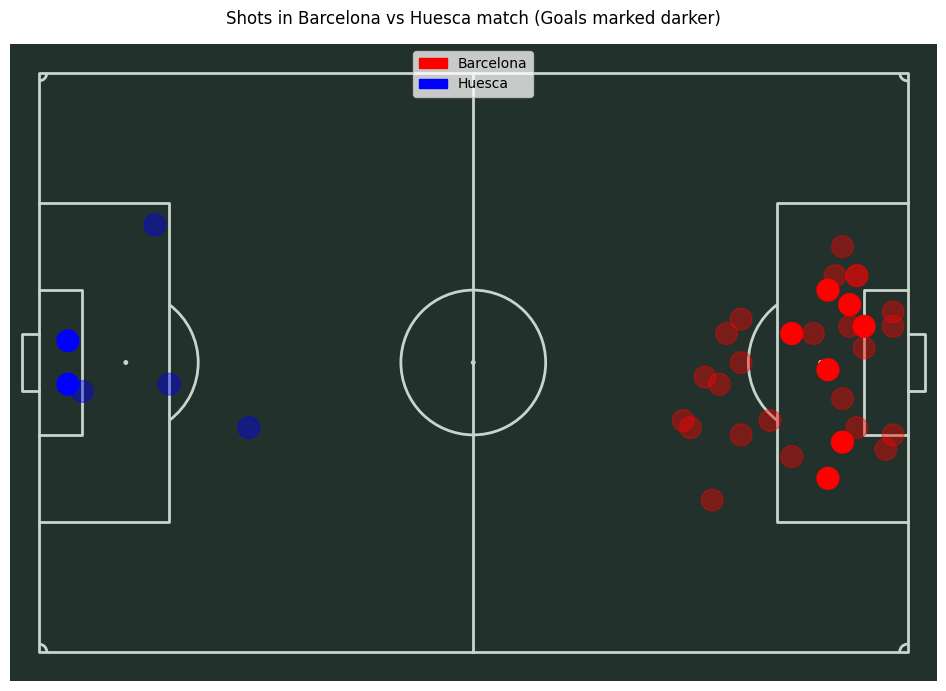

In [114]:
fig = create_shotmap(df,"Both")
fig.savefig("Barca vs Huesca",bbox_inches=None)

# Position of Players when Goal Scored

In [125]:
def get_player_pos_goal(goal_id,freeze,df,pitchtype,half):
    
    """
    goal_id:str --->> dataframe id to investigate
    freeze,df -->> the freeze and the main df
    pitchtype:str --->> Vertical/Normal(Horizontal)
    half:Boolean -->> True/False (To viz just the one half of the football Field or to viz entire field)
    
    
    returns -->> Figure with Position of players when goal scored
    """
    
    ###Create a Pitch####
    if pitchtype.lower() == "vertical":
        pitch = VerticalPitch(pitch_type = "statsbomb",pitch_color='#22312b', line_color='#c7d5cc',corner_arcs=True, \
             goal_type="box",stripe=False,half=half)
        fig, ax = pitch.draw(figsize=(8,10))
    else:
        pitch = Pitch(pitch_type = "statsbomb",pitch_color='#22312b', line_color='#c7d5cc',corner_arcs=True, \
             goal_type="box",stripe=False,half=half)
        fig, ax = pitch.draw(figsize=(8,10))
        
    ###################
    
    team1,team2 = df["team_name"].unique()
    colors = {team1:"#FF3131",team2:"#1F51FF"}
    
    #########################
    freeze_stats = freeze.loc[freeze["id"] == goal_id]
    ########plotting the Freezed location of Players during Goal#####
    #xpos,ypos,player_team = [],[],[]
    for i in range(len(freeze_stats)):
        player_id,player_name = freeze_stats.iloc[i]["player_id"],freeze_stats.iloc[i]["player_name"]
        player_posx,player_posy = freeze_stats.iloc[i]["x"],freeze_stats.iloc[i]["y"]
        
        player_poition_name = freeze_stats.iloc[i]["position_name"]
        player_pos_initials = "".join(i[0] for i in player_poition_name.split(" "))
        #xpos.append(player_posx)
        #ypos.append(player_posy)
        player_team = df.loc[df["player_id"]==player_id]["team_name"].unique()[0]
        if pitchtype.lower() == "vertical": 
            shot_circle = plt.Circle((player_posy,player_posx),1.5,color=colors[player_team])
            plt.text(player_posy-1,player_posx-2,player_pos_initials,color="white")
        else:
            shot_circle = plt.Circle((player_posx,player_posy),1.5,color=colors[player_team])
            plt.text(player_posx+1,player_posy-2,player_pos_initials,color="white")
        shot_circle.set_alpha(0.4)
        ax.add_patch(shot_circle)
    ######################################
    
    
    
    ##########Plotting the Goal Scorer#######
    goal_scorer,goal_scorer_id = df.loc[df["id"]==goal_id]["player_name"].values[0],int(df.loc[df["id"]==goal_id]["player_id"])
    goal_scorer_team = df.loc[df["id"]==goal_id]["team_name"].values[0]
    goal_scorer_pos = df.loc[df["id"]==goal_id]["position_name"].values[0]
    player_pos_initials = "".join(i[0] for i in goal_scorer_pos.split(" "))
    
    opposing_team = list(set(df["possession_team_name"]).difference({goal_scorer_team}))[0]
    #######Get the goal scored start and endpoints########
    shot_start_x,shot_start_y = df.loc[df["id"]==goal_id]["x"].values[0],df.loc[df["id"]==goal_id]["y"].values[0]
    shot_end_x,shot_end_y = df.loc[df["id"]==goal_id]["end_x"].values[0],df.loc[df["id"]==goal_id]["end_y"].values[0]
    #print(shot_start_x,shot_start_y)
    color_code = colors[goal_scorer_team]
    if pitchtype.lower() == "vertical":
        shot_circle = plt.Circle((shot_start_y,shot_start_x),1.5,color=color_code)
        #plt.text(shot_start_y-1,shot_start_x-2,player_pos_initials,color="white")
        #plt.text(shot_start_y+1,shot_start_x-2,)
    else:
        shot_circle = plt.Circle((shot_start_x,shot_start_y),1.5,color=color_code)
        #plt.text(shot_start_x+1,shot_start_y-2,player_pos_initials,color="white")
        
    shot_circle.set_alpha(1)
    
    ax.add_patch(shot_circle)
    ############################
    
    ### Plotting the arrow of the Shot###
    dx=shot_end_x - shot_start_x
    dy=shot_end_y - shot_start_y
    #plot arrow
    if pitchtype.lower() == "vertical":
        passArrow=plt.Arrow(shot_start_y,shot_start_x,dy,dx,width=2,color="#39FF14")
    else:
        passArrow=plt.Arrow(shot_start_x,shot_start_y,dx,dy,width=2,color="#39FF14")

        
    ax.add_patch(passArrow)
    ###########################
    
    fig.suptitle("Player Position during {}'s Goal vs {}".format(goal_scorer,opposing_team))
    fig.set_size_inches(10, 7)
    #plt.colorbar(colors)
    #ax.legend()
    team1_patch = mpatches.Patch(color=colors[team1], label=team1)
    team2_patch = mpatches.Patch(color=colors[team2], label=team2)
    if pitchtype.lower() == "vertical":
        position = "upper right"
    else:
        position = "upper right"
    ax.legend(handles=[team1_patch, team2_patch],loc=position,framealpha=0.75,labelcolor="black")
    return fig

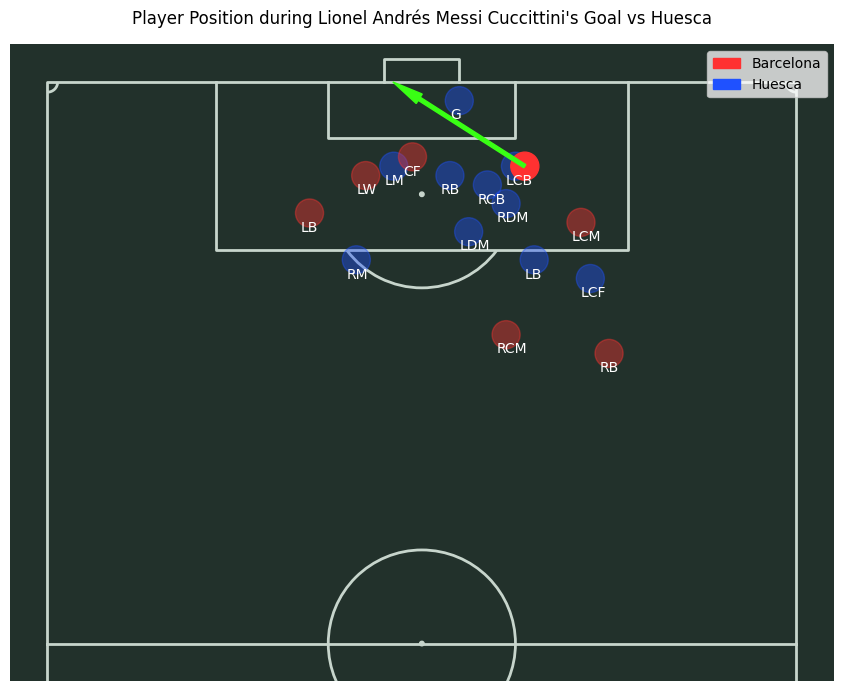

In [126]:
f  = get_player_pos_goal("5e301e10-a9f2-4504-9d98-ecddbab86ed4",freeze,df,"Vertical",True)
f.savefig("Player Position during Messi's Goal vs Huesca",bbox_inches=None)

In [ ]:
f.savefig()